[View in Colaboratory](https://colab.research.google.com/github/jpskycak/research_notebooks/blob/master/modeling_programmable_self_assembly_with_cellular_automata.ipynb)

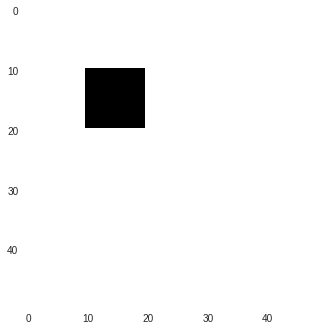

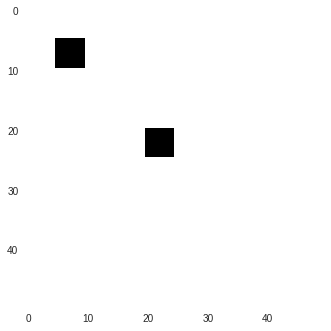

[(5, 5), (5, 6), (5, 7), (5, 8), (5, 9)]

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random

# initial coordinates for agents
L = 10
scaling_factor = 5
gridshape = (scaling_factor*L,scaling_factor*L)
grid = np.zeros(gridshape)
grid[L:2*L,L:2*L] = 1
plt.imshow(grid)
plt.grid(False)
plt.show()

# make shape
shape = np.zeros(gridshape)

#shape[:L,:L] = 1

shape[L-5:L,L-5:L] = 1
shape[2*L:2*L+5,2*L:2*L+5] = 1

#shape[L:-3,L:-3] = 1
#shape[int(1.25*L):-3,int(1.25*L):-3] = 0 

plt.imshow(shape)
plt.grid(False)
plt.show()

shape_coordinates = []
for x in range(shape.shape[0]):
  for y in range(shape.shape[1]):
    if shape[x,y] == 1:
      shape_coordinates.append((x,y))
shape_coordinates[:5]

In [21]:
# instantiate agents at initial coordinates
# initialize estimated coordinates as true initial coordinates
# update_neighbors_and_distances()

agents = []

for x in range(gridshape[0]):
  for y in range(gridshape[1]):
    if grid[x,y]==1:
      agents.append({'true_coordinates':(x,y),
                     'estimated_coordinates':(x,y),
                     'orientation':(-1,0),
                     'id':len(agents),
                     'is_source':bool((x,y)==(2*L-1,2*L-1))
                    })

def distance_metric(a,b):
  return max(abs(a[0]-b[0]),abs(a[1]-b[1]))
  #return abs(a[0]-b[0])+abs(a[1]-b[1])

def in_radius(test_point,center,radius):
  out = False
  if distance_metric(test_point,center) <= radius:
    out = True
  return out

def get_neighbors_distances_estimations(agent,radius=1):
  center = agent['true_coordinates']
  neighbors = [i for i,a in enumerate(agents) if in_radius(a['true_coordinates'],center,radius) and a['id'] != agent['id']]
  distances = [distance_metric(agents[i]['true_coordinates'],center) for i in neighbors]
  estimated_coordinates = agent['estimated_coordinates']
  
  if len(neighbors)>0:
  
    neighbors_estimated_coordinates = [agents[n]['estimated_coordinates'] for n in neighbors]
    # DEBUG: print 'neighbors for agent id ',agent['id'],' at ',center,'are: ',neighbors
    def error_estimated_coordinates(xy):
      discrepancies = [d - distance_metric(xy,neighbors_estimated_coordinates[i]) for i,d in enumerate(distances)]
      return sum([abs(d) for d in discrepancies])

    neighbors_estimated_coordinates_x = [c[0] for c in neighbors_estimated_coordinates]
    neighbors_estimated_coordinates_y = [c[1] for c in neighbors_estimated_coordinates]
    [min_x, max_x] = [min(neighbors_estimated_coordinates_x), max(neighbors_estimated_coordinates_x)]
    [min_y, max_y] = [min(neighbors_estimated_coordinates_y), max(neighbors_estimated_coordinates_y)]
    candidate_estimations = list(itertools.product(range(min_x,max_x+1),range(min_y,max_y+1)))
    candidate_estimation_errors = [error_estimated_coordinates(xy) for xy in candidate_estimations]

    optimal_estimations = [candidate_estimations[i] for i,err in enumerate(candidate_estimation_errors) if err==min(candidate_estimation_errors)]
    estimated_coordinates = random.choice(optimal_estimations)
  
  return [neighbors,distances,estimated_coordinates]


for a in agents:
  [a['neighbors'],a['distances'],a['estimated_coordinates']] = get_neighbors_distances_estimations(a)
  
agents[0]

{'distances': [1, 1, 1],
 'estimated_coordinates': (10, 10),
 'id': 0,
 'is_source': False,
 'neighbors': [1, 10, 11],
 'orientation': (-1, 0),
 'true_coordinates': (10, 10)}

In [22]:
# initialize gradient values.

for a in agents:
  if a['is_source']:
    a['gradient_value'] = 0
    for neighbor_index in a['neighbors']:
      neighbor = agents[neighbor_index]
      neighbor['gradient_value'] = 1
      
def do_all_agents_have_gradient_values():
  ans = True
  for a in agents:
    if 'gradient_value' not in a.keys():
      ans = False
  return ans

while not do_all_agents_have_gradient_values():
  for a in agents:
    if 'gradient_value' not in a.keys():
      neighbors = [agents[i] for i in a['neighbors']]
      min_gradient_in_neighbors = 9*10**10
      should_assign_gradient_value = False
      for neighbor in neighbors:
        if 'gradient_value' in neighbor.keys():
          min_gradient_in_neighbors = min(neighbor['gradient_value'],min_gradient_in_neighbors)
          should_assign_gradient_value = True
      if should_assign_gradient_value:
        a['gradient_value'] = 1+min_gradient_in_neighbors
  
agents[0]

{'distances': [1, 1, 1],
 'estimated_coordinates': (10, 10),
 'gradient_value': 9,
 'id': 0,
 'is_source': False,
 'neighbors': [1, 10, 11],
 'orientation': (-1, 0),
 'true_coordinates': (10, 10)}

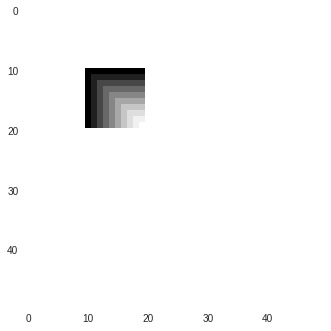

In [23]:
# check gradient
gradient = np.zeros(gridshape)
for a in agents:
  [x,y] = a['true_coordinates']
  gradient[x,y] = a['gradient_value']
  
plt.imshow(gradient)
plt.grid(False)
plt.show()

In [0]:
# edge-following
def leaves_shape(old_loc,new_loc):
  ans = False
  if old_loc in shape_coordinates:
    if new_loc not in shape_coordinates:
      ans = True
  return ans
  
def can_move(a):
  neighbors = a['neighbors']
  (x0,y0) = a['true_coordinates']
  (dx,dy) = a['orientation']
  (x,y) = (x0+dx,y0+dy)

  ans = False
  occupied = [agents[neighbors[i]]['true_coordinates'] for i,d in enumerate(a['distances']) if d==1]
  if (x,y) not in occupied: # not occupied
    if x in range(gridshape[0]) and y in range(gridshape[1]): # in grid
      if not leaves_shape((x0,y0),(x,y)): # doesn't leave shape
        ans = True
  return ans

def move(a):
  (x,y) = a['true_coordinates']
  (dx,dy) = a['orientation']
  a['true_coordinates'] = (x+dx,x+dy)

def turn(a):
  seq = [(-1,0),(0,1),(1,0),(0,-1)]
  i = seq.index(a['orientation'])
  return seq[(i+1)%4]

def update(a):
  [a['neighbors'],a['distances'],a['estimated_coordinates']] = get_neighbors_distances_estimations(a)

def timestep(agents=agents,shape_coordinates=shape_coordinates):
                
  movable_agents = [i for i,a in enumerate(agents) if can_move(a)]
  selected_agent = agents[random.choice(movable_agents)]
  move(selected_agent)
  update(selected_agent)
  if not can_move(selected_agent): # if it can't move again, then it's on corner (?)
    turn(selected_agent)
                              
  old_neighbors = selected_agent['neighbors']              
  update(selected_agent)
  new_neighbors = selected_agent['neighbors']
  
  for i in list(set(old_neighbors).union(set(new_neighbors))):
    update(agents[i]) 

def plot_grid():
  grid = np.zeros((scaling_factor*L,scaling_factor*L))
  for s in shape_coordinates:
    grid[s]=0.5
  for a in agents:
    grid[a['true_coordinates']]=1
  plt.imshow(grid)
  plt.grid(False)
  plt.show()
  

t=0


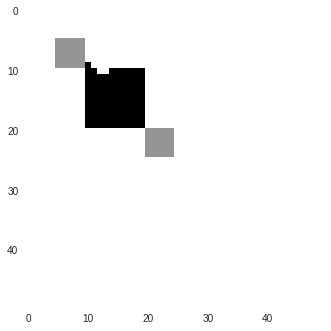

t=100


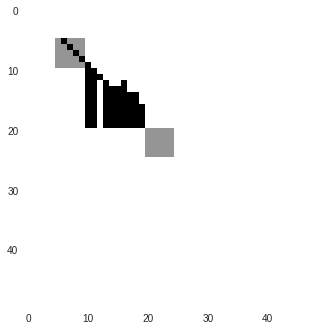

t=200


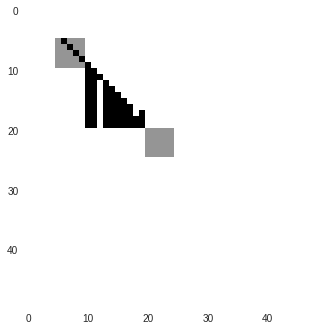

t=300


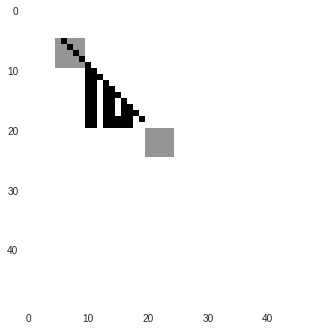

t=400


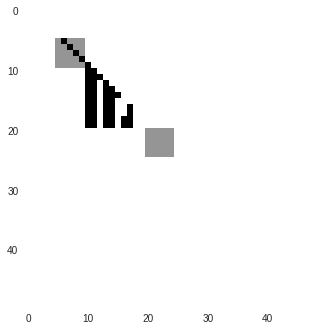

t=500


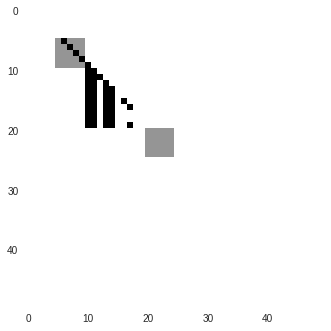

t=600


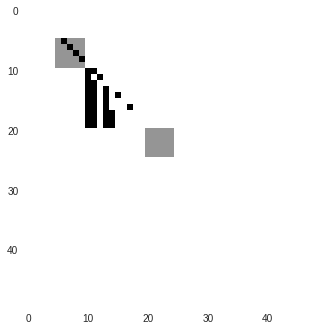

t=700


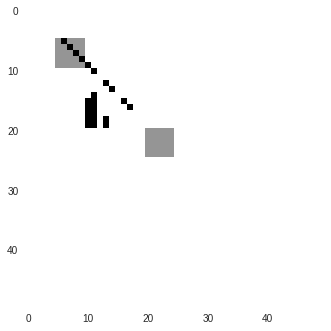

t=800


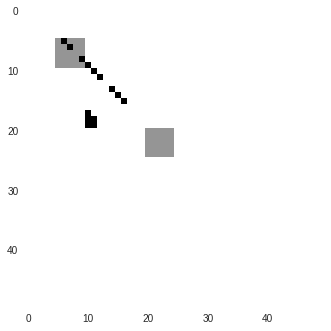

t=900


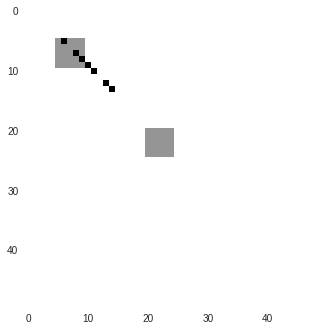

IndexError: ignored

In [31]:
for t in range(1000):
  timestep()
  if t%100==0:
    print 't='+str(t)
    plot_grid()

incorrect stuff that I will delete:

In [97]:
# edge-following

def unit_neighbors(agent):
  return [n for i,n in enumerate(agent['neighbors']) if agent['distances'][i]==1]

# 0 1 2
# 7 x 3
# 6 5 4

unit_circle = [(-1,1),(0,1),(1,1),(1,0),(1,-1),(0,-1),(-1,-1),(-1,0)]

unit_semicircles = [
    [unit_circle[n%8] for n in range(0,4)],
    [unit_circle[n%8] for n in range(1,5)],
    [unit_circle[n%8] for n in range(2,6)],
    [unit_circle[n%8] for n in range(3,7)],
    [unit_circle[n%8] for n in range(4,8)],
    [unit_circle[n%8] for n in range(5,9)],
    [unit_circle[n%8] for n in range(6,10)],
    [unit_circle[n%8] for n in range(7,11)]
]



edge_templates_numbers = [] # only need to consider cases which are actually an edge (i.e. semicircle is open)
for n in range(8):
  edge_templates_numbers.append(([n],[(n+1)%8, (n-1)%8]))
  edge_templates_numbers.append(([n,(n+1)%8],[(n-1)%8, (n+2)%8]))  
  edge_templates_numbers.append(([n,(n+1)%8,(n+2)%8],[(n-1)%8, (n+3)%8]))  
  edge_templates_numbers.append(([n,(n+1)%8,(n+2)%8,(n+3)%8],[(n-1)%8, (n+4)%8]))

edge_templates = []
for (template,moves) in edge_templates_numbers:
  template_tuples = [unit_circle[n] for n in template]
  moves_tuples = [unit_circle[n] for n in moves]
  edge_templates.append((set(template_tuples),moves_tuples))
  
def get_edge_template_moves(occupied_displacements):
  d = set(occupied_displacements)
  ans = [(0,0)]
  for (template,moves) in edge_templates:
    if d == template:
      ans = moves
      break
  return ans

def valid_moves(agent):
  # if there is a nonoccupied semicircle, then agent can move to one of the follows according to its edge template
  
  (x,y) = agent['true_coordinates']
  neighbor_coordinates = [agents[n]['true_coordinates'] for n in unit_neighbors(agent)]
  occupied_displacements = [(dx,dy) for (dx,dy) in unit_circle if (x+dx,y+dy) in neighbor_coordinates]
  nonoccupied_displacements = [d for d in unit_circle if d not in occupied_displacements]
  agent_is_on_edge = any([set(s)<=set(nonoccupied_displacements) for s in unit_semicircles])
  
  if not agent_is_on_edge:
    valid_moves = [(0,0)]
  else:
    edge_template_moves = get_edge_template_moves(occupied_displacements)
    nonoccupied_displacements_in_grid = [(dx,dy) for (dx,dy) in nonoccupied_displacements if x+dx in range(gridshape[0]) and y+dy in range(gridshape[1])]
    valid_moves = list(set(edge_template_moves).intersection(nonoccupied_displacements_in_grid))
    if valid_moves==[]:
      valid_moves = [(0,0)]
  return valid_moves

def estimated_distance_to_shape(agent,prospective_move):
  (x,y) = agent['estimated_coordinates']
  (dx,dy) = prospective_move
  prospective_estimated_coordinates = (x+dx,y+dy)
  distances = [distance_metric(prospective_estimated_coordinates,p) for p in shape_coordinates]
  return min(distances)

def chosen_move(agent,shape_coordinates):
  prospective_moves = valid_moves(agent)
  prospective_distances = [estimated_distance_to_shape(agent,m) for m in prospective_moves]
  min_distance = min(prospective_distances)
  optimal_moves = [prospective_moves[i] for i,d in enumerate(prospective_distances) if d==min_distance]
  # DEBUG - print 'chosen_displacement - displacements:',displacements
  # DEBUG - print 'chosen_displacement - distances:',distances
  # DEBUG - print 'chosen_displacement - optimal_displacements:',optimal_displacements
  return random.choice(optimal_moves)

print valid_moves(agents[-2])
print [estimated_distance_to_shape(agents[-2],d) for d in valid_moves(agents[-2])]
print chosen_move(agents[-2],shape_coordinates) 

[(0, 0)]
[2]
(0, 0)


In [0]:
def timestep(agents=agents,shape_coordinates=shape_coordinates):
  (dx,dy) = (0,0)
  while (dx,dy) == (0,0):
    movable_agents = [i for i,a in enumerate(agents) if len(valid_moves(a))>1]
    #print movable_agents
    selected_agent = agents[random.choice(movable_agents)]

    #print selected_agent
    #print 'valid moves:',valid_moves(selected_agent)
    #print 'distance to shape for each move:',[estimated_distance_to_shape(selected_agent,d) for d in valid_moves(selected_agent)]
    (x,y) = selected_agent['true_coordinates']
    (dx,dy) = chosen_move(selected_agent,shape_coordinates)
    #print 'chosen move:',(dx,dy)
    
  selected_agent['true_coordinates'] = (x+dx,y+dy)
  previous_neighbors = selected_agent['neighbors']
  
  def update_agent(a):
    [a['neighbors'],a['distances'],a['estimated_coordinates']] = get_neighbors_distances_estimations(a)
  update_agent(selected_agent)
  new_neighbors = selected_agent['neighbors']
  
  agents_to_update = list(set(previous_neighbors).union(set(new_neighbors)))
  for i in agents_to_update:
    update_agent(agents[i]) 

def plot_grid():
  grid = np.zeros((scaling_factor*L,scaling_factor*L))
  for s in shape_coordinates:
    grid[s]=0.5
  for a in agents:
    grid[a['true_coordinates']]=1
  plt.imshow(grid)
  plt.grid(False)
  plt.show()

t=0


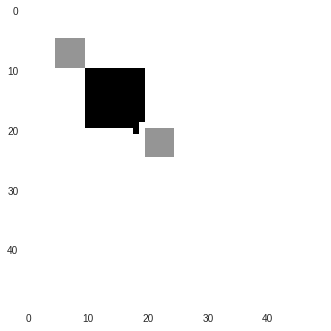

t=250


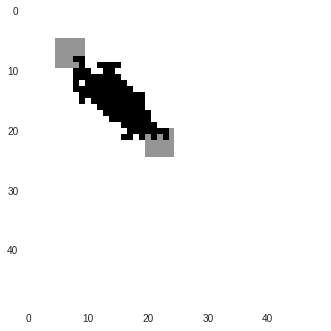

t=500


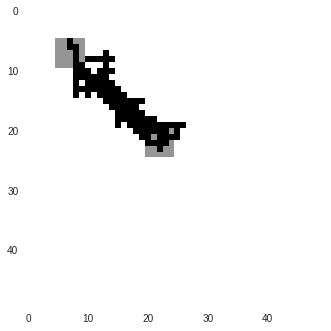

t=750


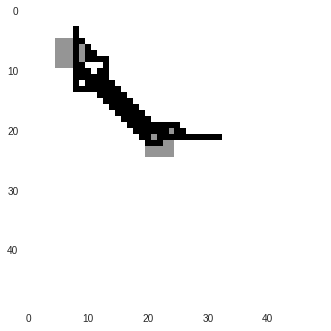

t=1000


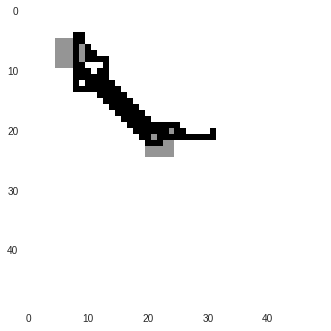

t=1250


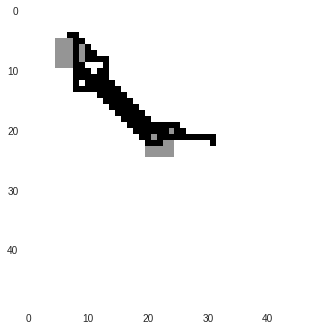

t=1500


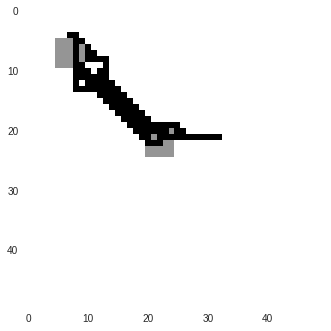

t=1750


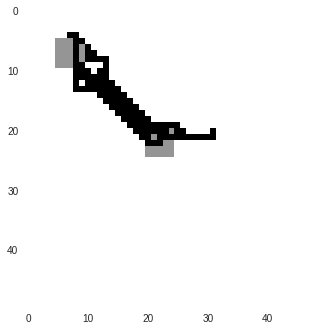

In [99]:
for t in range(2000):
  try:
    timestep()
  except: # gridlocked
    print 'GRIDLOCKED at t='+str(t)
    plot_grid()
    break
  if t%250==0:
    print 't='+str(t)
    plot_grid()

In [100]:
[]

[]